In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [3]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Resize((300, 300))
])

In [4]:
# 데이터셋 로드
img_root = 'data'
dataset = ImageFolder(root=img_root, transform=transform)


In [5]:
# 데이터셋 분할 (학습/검증/테스트)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [6]:
# 하이퍼파라미터 설정
batch_size = 32
num_epochs = 300
learning_rate = 0.001

In [7]:
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# VGG 모델 로드 및 전이학습 설정
vgg = models.vgg16(pretrained=True)

# VGG 첫 번째 컨볼루션 레이어의 입력 채널 수 수정
vgg.features[0] = nn.Conv2d(1, 64, kernel_size=5, padding=1)

for param in vgg.features.parameters():
    param.requires_grad = False



c:\Users\Administrator\Downloads\OpenCVTeam\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Downloads\OpenCVTeam\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_features = vgg.classifier[0].in_features
vgg.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(dataset.classes))
)

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# 모델 설정
model = vgg.to(DEVICE)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 리스트 정의
trainList = []
valList = []
testList = []

In [12]:
# 학습 함수
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        trainList.append(loss)
    return running_loss / len(loader)

In [13]:
# 검증 함수
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            valList.append(loss)
    return running_loss / len(loader)

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
SCHEDULERS = ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, verbose = True)
cnt = 0

# 학습 루프
best_val_loss = 10000
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    if SCHEDULERS.num_bad_epochs >= SCHEDULERS.patience:
        print(f"Early stopping at epoch {epoch}")
        break
    # print(epoch)

c:\Users\Administrator\Downloads\OpenCVTeam\.venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/300, Train Loss: 3.4949, Val Loss: 3.1447
Epoch 2/300, Train Loss: 3.0533, Val Loss: 2.7746
Epoch 3/300, Train Loss: 2.7324, Val Loss: 2.4128
Epoch 4/300, Train Loss: 2.4483, Val Loss: 2.0685
Epoch 5/300, Train Loss: 2.2575, Val Loss: 1.9255
Epoch 6/300, Train Loss: 2.0030, Val Loss: 1.6795
Epoch 7/300, Train Loss: 1.9251, Val Loss: 1.5846
Epoch 8/300, Train Loss: 1.7118, Val Loss: 1.3384
Epoch 9/300, Train Loss: 1.5795, Val Loss: 1.2896
Epoch 10/300, Train Loss: 1.5829, Val Loss: 1.2047
Epoch 11/300, Train Loss: 1.4613, Val Loss: 1.1466
Epoch 12/300, Train Loss: 1.3295, Val Loss: 1.0059
Epoch 13/300, Train Loss: 1.2431, Val Loss: 1.0343
Epoch 14/300, Train Loss: 1.2893, Val Loss: 0.9447
Epoch 15/300, Train Loss: 1.1510, Val Loss: 0.8915
Epoch 16/300, Train Loss: 1.1088, Val Loss: 0.7437
Epoch 17/300, Train Loss: 1.1167, Val Loss: 0.8454
Epoch 18/300, Train Loss: 1.0053, Val Loss: 0.7538
Epoch 19/300, Train Loss: 0.9337, Val Loss: 0.7248
Epoch 20/300, Train Loss: 0.9401, Val Lo

KeyboardInterrupt: 

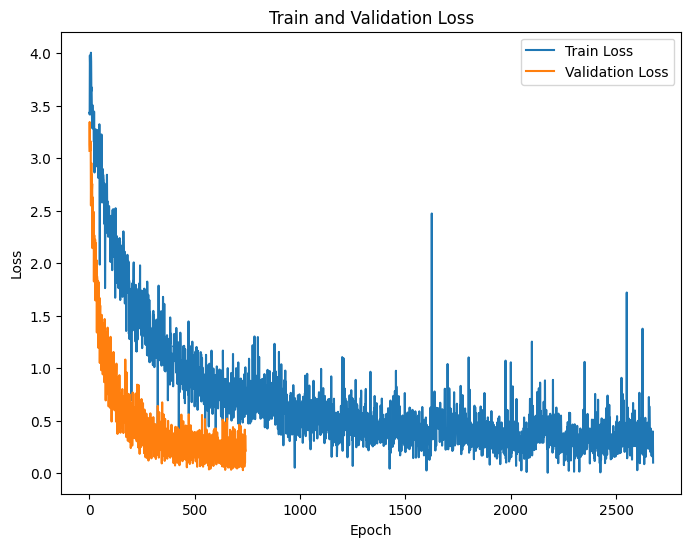

In [15]:
import matplotlib.pyplot as plt

# 에포크 loss 시각화
plt.figure(figsize=(8, 6))
x = range(1,len(trainList)+1)
plt.plot(x, torch.tensor(trainList).detach().numpy(), label='Train Loss')
x = range(1,len(valList)+1)
plt.plot(x, torch.tensor(valList).detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [16]:

# 테스트 함수
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    testList.append(accuracy)
    return accuracy


In [17]:

# 모델 로드 및 테스트
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = test(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 96.40%


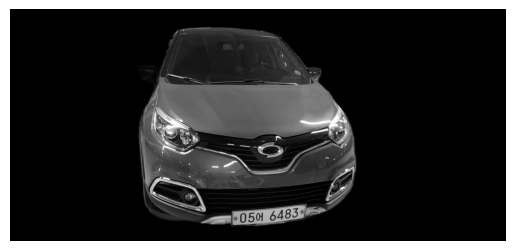

예측 클래스: 그랜저
예측 확률: 71.00%


In [22]:
from PIL import Image

# 테스트 결과 출력

img_path = 'test/image2.png'  # 테스트 이미지 경로

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 그레이스케일 변환
    transforms.ToTensor(),
    transforms.Resize((300, 300))
])

img = Image.open(img_path).convert('L')
img_tensor = transform(img).unsqueeze(0).to(DEVICE)

model.eval()

with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)

plt.imshow(img, cmap='gray')  # 그레이스케일 이미지로 표시
plt.axis('off')
plt.show()

# 결과 출력
prob = torch.softmax(output, dim=1).detach().cpu().squeeze().numpy()
max_prob = max(prob)
rounded_prob = round(max_prob, 2)

class_names = ["ev6","ev9","qm3","qm6","sm3","sm6","test","xm3","그랜저","넥쏘","더 뉴 아반떼","렉스턴","스타리아","싼타페","쏘나타","아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8","아이오닉5","아이오닉6","제네시스 g70","제네시스 g90","제네시스 gv70","코나","코란도","토레스","투싼"]  # 클래스 이름 리스트 (실제 클래스 이름으로 변경해야 함)
predicted_class = class_names[predicted.item()]

print(f"예측 클래스: {predicted_class}")
print(f"예측 확률: {rounded_prob*100:.2f}%")

In [23]:
class_names = ["test",]  # 클래스 이름 리스트 (실제 클래스 이름으로 변경해야 함)
brandList = {
    "현대" : ["그랜저","더 뉴 아반떼","스타리아","아이오닉5","아이오닉6","넥쏘","쏘나타","투싼", "코나","싼타페",],
    "기아" : ["ev6","ev9",],
    "르노" : ["qm3","qm6","sm3","sm6","xm3",],
    "제네시스" : ["제네시스 g70","제네시스 g90","제네시스 gv70",],
    "아우디"  : ["아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8",],
    "KG 모빌리티" : ["렉스턴","코란도","토레스",]
}

In [24]:

# 결과 출력
prob = torch.softmax(output, dim=1).detach().cpu().squeeze().numpy()
max_prob = max(prob)
rounded_prob = round(max_prob, 2)

class_names = ["ev6","ev9","qm3","qm6","sm3","sm6","test","xm3","그랜저","넥쏘","더 뉴 아반떼","렉스턴","스타리아","싼타페","쏘나타","아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8","아이오닉5","아이오닉6","제네시스 g70","제네시스 g90","제네시스 gv70","코나","코란도","토레스","투싼"]  # 클래스 이름 리스트 (실제 클래스 이름으로 변경해야 함)
predicted_class = class_names[predicted.item()]


for brand, models in brandList.items():
    if predicted_class in models:
        print(f"예측 브랜드: {brand}")
        break

print(f"예측 클래스: {predicted_class}")
print(f"예측 확률: {rounded_prob*100:.2f}%")

예측 브랜드: 현대
예측 클래스: 그랜저
예측 확률: 71.00%
